In [1]:
import tensorflow as tf # tensorflow dataset (Download the images into tf dataset structure image batch)
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd

2023-03-25 13:28:06.890097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Constant 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
# EPOCHS = 50 

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True, # randomly shuffle 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


There are 20638 files with 15 classes in the dataset.

In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset) # 68, batch of 32 images 

645

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) # (32, 256, 256, 1)
    print(label_batch.numpy()) # There are 15 classes

(32, 256, 256, 3)
[10  6  0  1 14  7 14  5 14  5  9 12  3 12  9  3 10  5 12 12 14 14  2  9
  2  0 10  2 12 12  2  0]


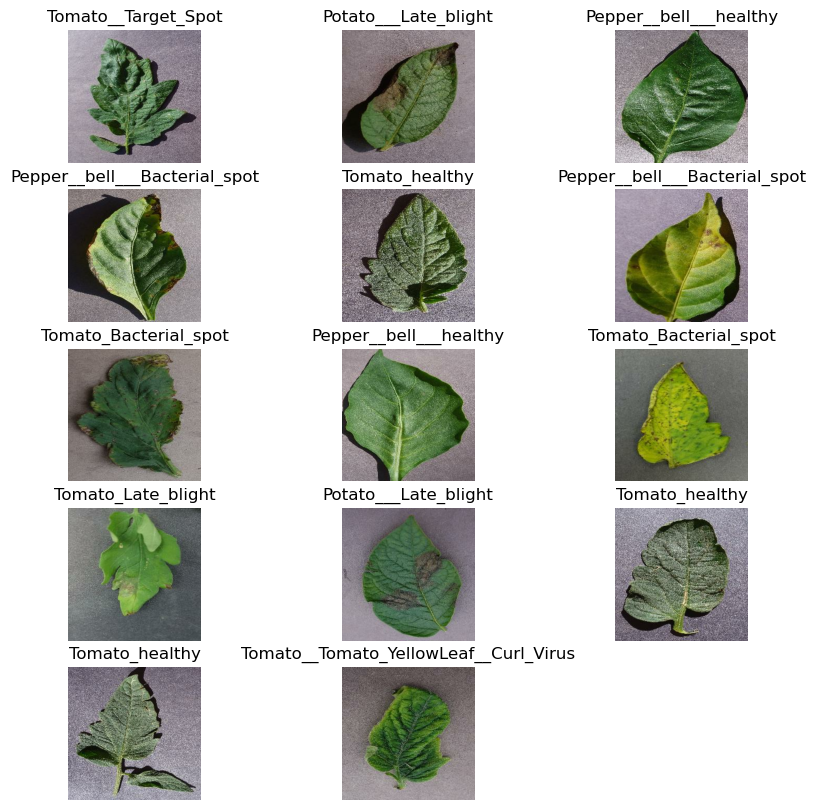

In [7]:
# Just to see what types of them - visualization
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(0, 14):
        ax=plt.subplot(5,3,i+1) # print them all at once in one page 
        plt.imshow(image_batch[i].numpy().astype("uint8")) # print first image, converted to int from float
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    # Shuffle = True, thereby the result is different everytime

##### test train data split
80% of training dataset </br>
20% out of training - validation set </br>
20% of test dataset

In [8]:
def test_train_split_tf(ds, train_split=0.8, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size) # train_set 80 % from total 
    val_size = int(val_split * train_size)  # 20 % from 80 % of total(train)
    test_size = int(test_split*ds_size)
    
    train_int = ds.take(train_size)    # first 516 dataset
    val_set = train_int.take(val_size) # first 20% of 80%
    train_set = train_int.skip(val_size).take(train_size-val_size) # remaining 
    test_set = ds.skip(train_size).take(test_size) 
    
    return train_set, val_set, test_set

In [9]:
train_set, val_set, test_set = test_train_split_tf(dataset)

In [10]:
len(train_set) +len(val_set)+len(test_set)

645

In [11]:
len(dataset)

645

##### Cache, Shuffle, and Prefetch the Dataset
When working with large datasets, it is often useful to cache, shuffle, and prefetch the dataset to improve training performance.</br>
</br>
<b>Caching</b> a dataset stores its elements in memory or on disk, so they don't need to be reloaded from disk for each epoch. </br>This can significantly speed up training when the data is read from disk. </br>Caching can be particularly useful when using complex preprocessing steps, as it allows you to perform the preprocessing once and then cache the preprocessed data.</br>
</br>
<b>Shuffling</b> the dataset is important to ensure that the model doesn't overfit to the order of the examples. </br>Randomizing the order of the examples helps ensure that the model sees a representative sample of the data during training.</br>
</br>
<b>Prefetching</b> the dataset allows the model to load data while it is still training on the previous batch. </br>This can help reduce the time it takes to load the data and can help keep the GPU or CPU busy during training.</br>

In [12]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Modelling

##### Data preprocessing layers
To increase the efficiency, resize the image and normalize the image pixel values to in range of 0 and 1. (dividing by 256)

In [13]:
# two preprocessing layers for preprocessing the dataset before fitting into the neural network model.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

##### Data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_set = train_set.map(
    lambda x,y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Model Architecture

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # (32, 256, 256, 3)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (32, 60, 60, 64)         

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [40]:
history = model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    validation_data=val_set,
    verbose=1,
    epochs=50,
)

Epoch 1/50
413/413 [==============================] - 479s 1s/step - loss: 1.8799 - accuracy: 0.3910 - val_loss: 1.6814 - val_accuracy: 0.4660
Epoch 2/50
413/413 [==============================] - 554s 1s/step - loss: 1.0555 - accuracy: 0.6479 - val_loss: 1.7050 - val_accuracy: 0.4885
Epoch 3/50
413/413 [==============================] - 469s 1s/step - loss: 0.7751 - accuracy: 0.7365 - val_loss: 1.0251 - val_accuracy: 0.6732
Epoch 4/50
413/413 [==============================] - 461s 1s/step - loss: 0.6088 - accuracy: 0.7902 - val_loss: 0.9797 - val_accuracy: 0.6811
Epoch 5/50
413/413 [==============================] - 461s 1s/step - loss: 0.5118 - accuracy: 0.8227 - val_loss: 0.7588 - val_accuracy: 0.7542
Epoch 6/50
413/413 [==============================] - 449s 1s/step - loss: 0.4450 - accuracy: 0.8447 - val_loss: 1.5023 - val_accuracy: 0.5856
Epoch 7/50
413/413 [==============================] - 472s 1s/step - loss: 0.3992 - accuracy: 0.8590 - val_loss: 1.1234 - val_accuracy: 0.6496

In [51]:
scores = model.evaluate(test_set)

129/129 [==============================] - 33s 251ms/step - loss: 0.4286 - accuracy: 0.8791


In [52]:
scores

[0.42857876420021057, 0.8791182041168213]

Plotting the Accuracy and Loss Curves

In [53]:
history

In [54]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 413}

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
type(history.history['loss'])

list

In [57]:
len(history.history['loss'])

50

In [58]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.8798515796661377,
 1.0554633140563965,
 0.7751494646072388,
 0.6088387370109558,
 0.5117582678794861]

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

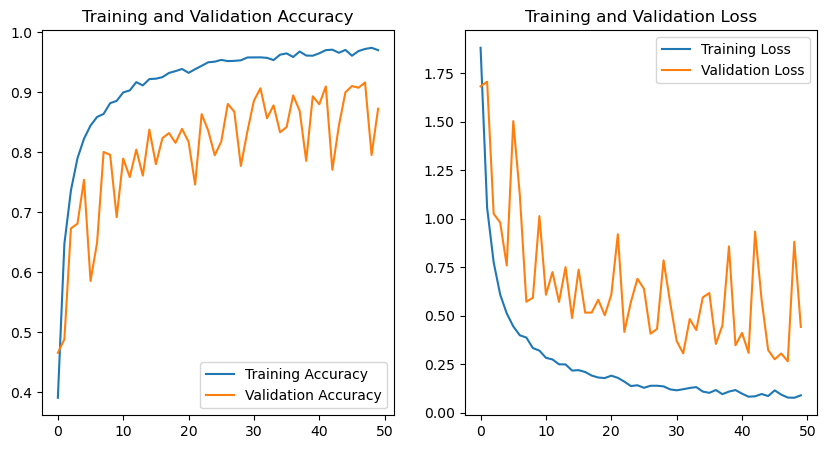

In [76]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


##### Result looks bit over fitted...These can be the solutions. 
Add more training data: Increasing the amount of training data can help the model generalize better and reduce overfitting. </br>
Data augmentation: Data augmentation techniques such as random cropping, flipping, and rotation can be used to artificially increase the size of the training dataset and make the model more robust to variations in the input.</br>
Regularization: Regularization techniques such as dropout or L2 regularization can be used to prevent overfitting by adding a penalty term to the loss function.</br>
Early stopping: You can monitor the validation loss during training and stop training early if the validation loss starts to increase. This can help prevent overfitting by stopping the model from learning noise in the training data.</br>
Adjusting the architecture: You can also try adjusting the architecture of the model, such as reducing the number of layers or neurons, to simplify the model and prevent overfitting.</br>
Hyperparameter tuning: Adjusting hyperparameters such as learning rate, batch size, and optimizer can also help improve the model's performance and prevent overfitting.</br>

Run prediction on a sample image

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 1s 511ms/step
predicted label: Pepper__bell___healthy


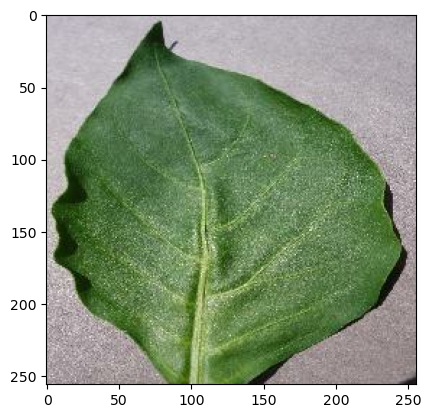

In [62]:
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


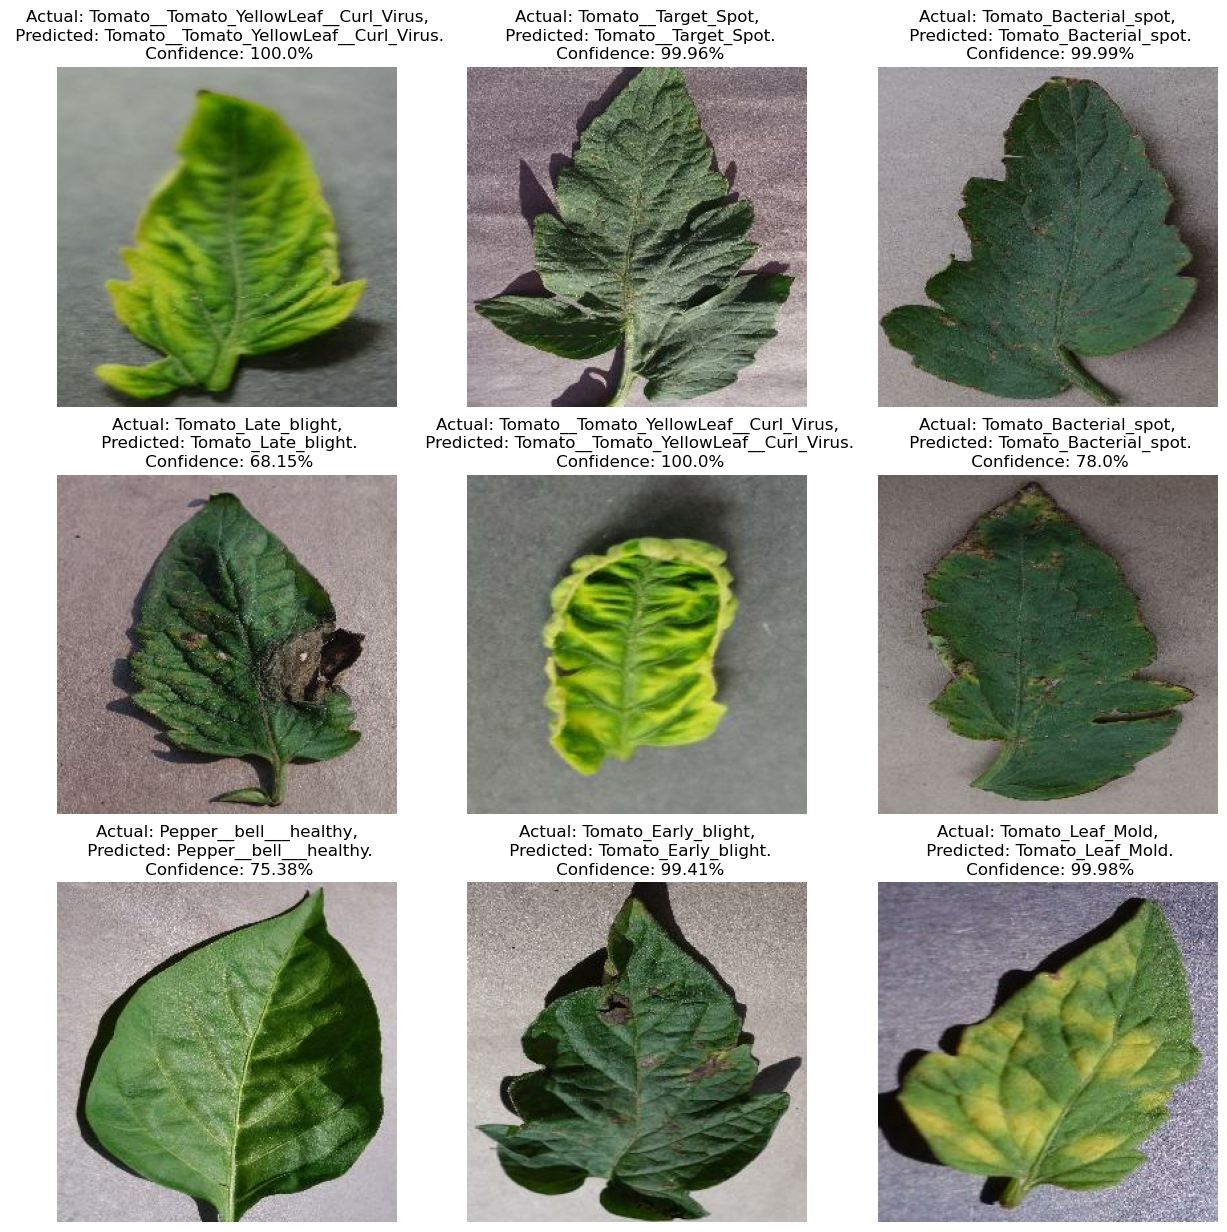

In [64]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [72]:
import os

# Create the directory for the models if it doesn't exist
model_dir = "../potato_disease/CNN_keras_file"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Determine the version number for this model
model_version = max([int(i) for i in os.listdir(model_dir) if i.isdigit()] + [0]) + 1

# Save the model to a file named "model_version.h5" in the subdirectory
model_path = os.path.join(model_dir, str(model_version) + ".h5")
model.save(model_path)

In [73]:
model.save("../potato_disease//potatoes.h5")